In [2]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [3]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [4]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [5]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


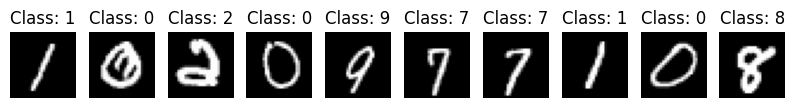

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [7]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [8]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [9]:
nonlinear_model = NonlinearClassifier()
print(nonlinear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [10]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [11]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [12]:
%%time

epochs =20
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 2.0098269440333048, accuracy: 57.318749999999994
Epoch 1: training loss: 1.0668870490392048, accuracy: 76.47708333333333
Epoch 2: training loss: 0.6577593752543132, accuracy: 82.66875
Epoch 3: training loss: 0.5222332801818848, accuracy: 85.67291666666667
Epoch 4: training loss: 0.45386946527163186, accuracy: 87.48541666666667
Epoch 5: training loss: 0.41312276045481366, accuracy: 88.64583333333333
Epoch 6: training loss: 0.38599390478928886, accuracy: 89.2875
Epoch 7: training loss: 0.3659672703742981, accuracy: 89.77291666666667
Epoch 8: training loss: 0.34996871058146156, accuracy: 90.23958333333333
Epoch 9: training loss: 0.33653337597846983, accuracy: 90.575
Epoch 10: training loss: 0.32489494705200195, accuracy: 90.89166666666667
Epoch 11: training loss: 0.31464486837387085, accuracy: 91.16250000000001
Epoch 12: training loss: 0.30546602980295817, accuracy: 91.4125
Epoch 13: training loss: 0.2971519376436869, accuracy: 91.63333333333334
Epoch 14: training 

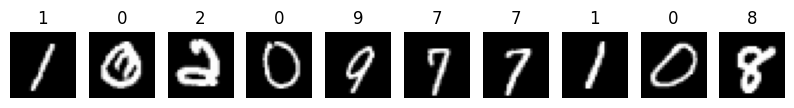

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
nonlinear_model.eval()
batch = next(iter(train_dataloader))
predictions = nonlinear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

In [15]:
acc_val, loss_val = evaluate(val_dataloader, nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.2519, validation accuracy: 92.71%


In [17]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2520, test accuracy: 92.67%


In [18]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


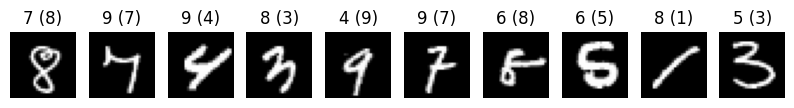

In [19]:
show_failures(nonlinear_model, val_dataloader)

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


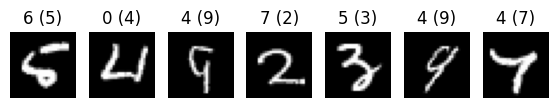

In [20]:
show_failures(nonlinear_model, test_dataloader)